In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import re # Regular expression matching
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os, glob, pickle, gc
import math

mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['font.size'] = 28


In [2]:
from matplotlib.ticker import FuncFormatter
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def formatter(x,pos):
    return format(np.log10(x), '.0f')

In [3]:
# Plot area sizes...
left, width = 0.125, 0.7
bottom, height = 0.1, 0.85

plot_area = [left, bottom, width, height]

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5,.5,.5,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(-7.5,0,16)
ticks  =[-7,-6,-5,-4,-3,-2,-1,0]
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [121]:
dotNorm = 10.0  # For dot-size scaling

In [122]:
z=16.0;sbox =  5.0 / (1.0 + z) * 0.71
i=770
print ("z=%.1lf, sbox=%.2lf"%(z,sbox))

z=16.0, sbox=0.21


In [160]:
x,y,zz = np.loadtxt("z%05.2f_SpCoord_%d.txt"%(z,i))
locs = np.loadtxt("spLocHaloOnly_%05.2f_%d.txt"%(z,i),skiprows=1) - np.array([x,y,zz]) # Normalize
mass = np.loadtxt("spMassHaloOnly_%05.2f_%d.txt"%(z,i),skiprows=1)
Z    = np.loadtxt("spZHaloOnly_%05.2f_%d.txt"%(z,i),skiprows=1) # SOLAR units in the file... 
PZ   = np.loadtxt("spPZHaloOnly_%05.2f_%d.txt"%(z,i),skiprows=1) # SOLAR units in the file... 
PPF  = np.loadtxt("spPPFHaloOnly_%05.2f_%d.txt"%(z,i),skiprows=1)

fpol = (1-PPF)
fpol[fpol<1e-5] = 0 # Don't let tiny numbers magnify Z !! Just use Z = 0 for these guys

# Do the correcting before fixing Z for subcritical values... otherwise, we bias Z/f_pol
Zf=Z/fpol # This is our Z corrected for f_pol
Zf[np.isinf(Zf)] = 10**-7.5 # Fix Zf for sp's with very very low polluted fractions. They are essentially pristine
Zf[np.isnan(Zf)] = 10**-7.5
Zf[Zf<1e-5] = 10**-7.5

Z[Z<1e-5] = 10**-7.5

PZf=PZ/fpol
PZf[np.isinf(PZf)] = 10**-7.5
PZf[np.isnan(PZf)] = 10**-7.5

PZ[PZ<1e-5] = 10**-7.5


/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


In [166]:
# Pick out stars by metallicity range... 
rng1 = (Z < 1.e-5)
rng2 = ((Z >= 1.e-5) & (Z < 1.e-3))
rng3 = ((Z >= 1.e-3) & (Z < 1.e-1))
rng4 = (Z >= 1.e-1)

# Pick out stars by corrected metallicity range... 
rngf1 = (Zf < 1.e-5)
rngf2 = ((Zf >= 1.e-5) & (Zf < 1.e-3))
rngf3 = ((Zf >= 1.e-3) & (Zf < 1.e-1))
rngf4 = (Zf >= 1.e-1)

# Pick out stars by pristine fraction, in ranges... 
pfrng1 = (PPF < 1.e-5)
pfrng2 = ((PPF >= 1.e-5) & (PPF < 1.e-3))
pfrng3 = ((PPF >= 1.e-3) & (PPF < 1.e-1))
pfrng4 = (PPF >= 1.e-1)

pzrng1 = (PZ < 1.e-5)
pzrng2 = ((PZ >= 1.e-5) & (PZ < 1.e-3))
pzrng3 = ((PZ >= 1.e-3) & (PZ < 1.e-1))
pzrng4 = (PZ >= 1.e-1)

pzrngf1 = (PZf < 1.e-5)
pzrngf2 = ((PZf >= 1.e-5) & (PZf < 1.e-3))
pzrngf3 = ((PZf >= 1.e-3) & (PZf < 1.e-1))
pzrngf4 = (PZf >= 1.e-1)

In [167]:
z1=np.log10(Z[rng1])
z2=np.log10(Z[rng2])
z3=np.log10(Z[rng3])
z4=np.log10(Z[rng4])

zf1=np.log10(Zf[rngf1]) # zf is the corrected Z of the star particle
zf2=np.log10(Zf[rngf2])
zf3=np.log10(Zf[rngf3])
zf4=np.log10(Zf[rngf4])

pf1=np.log10(PPF[pfrng1])
pf2=np.log10(PPF[pfrng2])
pf3=np.log10(PPF[pfrng3])
pf4=np.log10(PPF[pfrng4])

pz1=np.log10(PZ[pzrng1])
pz2=np.log10(PZ[pzrng2])
pz3=np.log10(PZ[pzrng3])
pz4=np.log10(PZ[pzrng4])

pzf1=np.log10(PZf[pzrngf1])
pzf2=np.log10(PZf[pzrngf2])
pzf3=np.log10(PZf[pzrngf3])
pzf4=np.log10(PZf[pzrngf4])

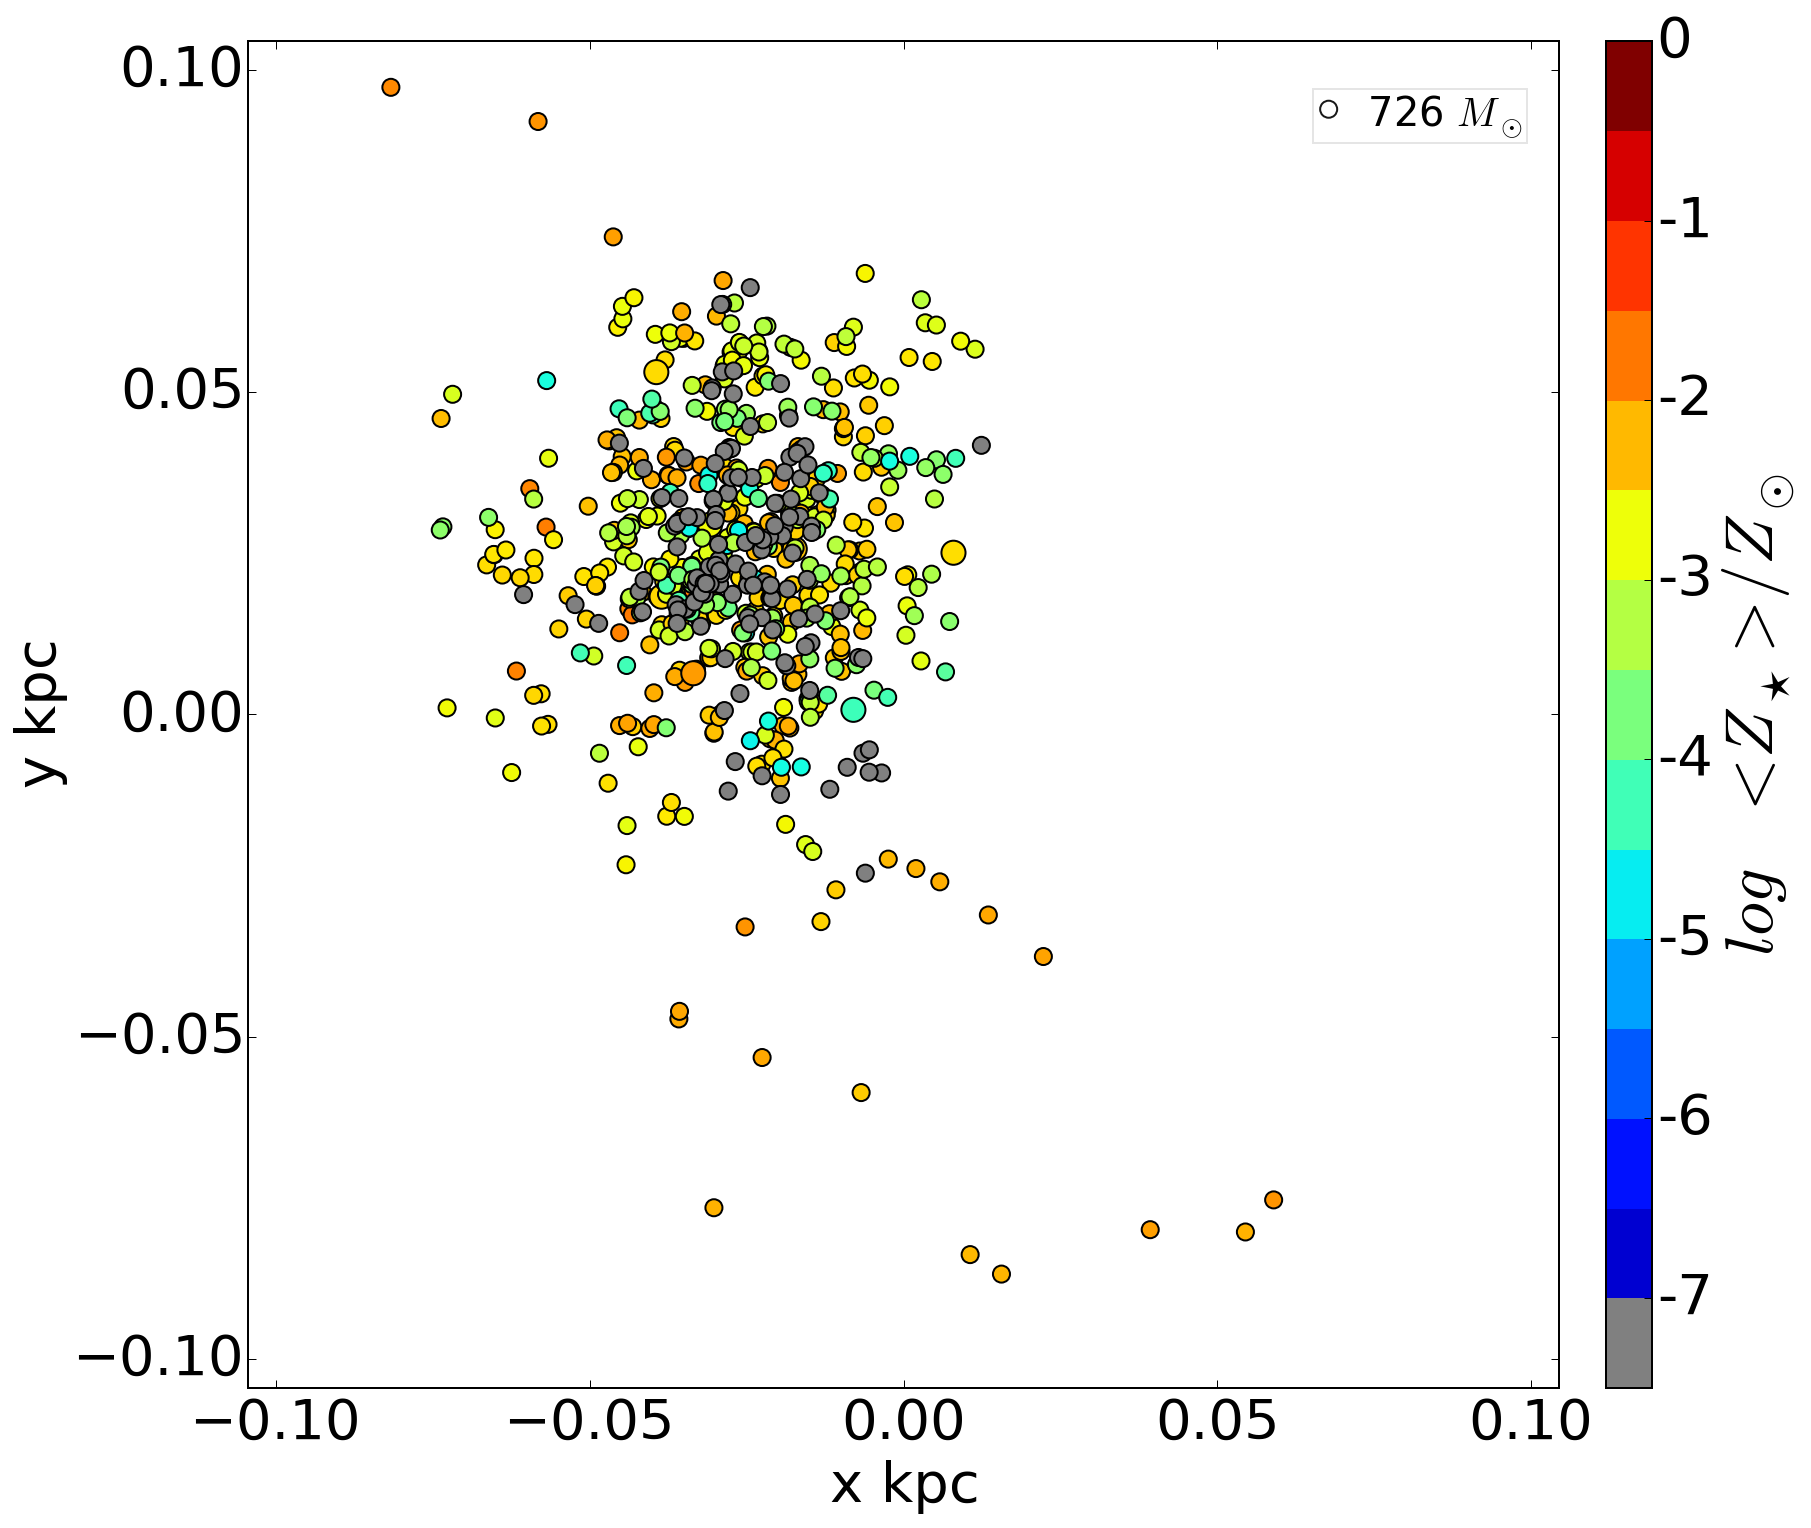

In [168]:
fig = plt.figure()
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
#plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
ax1 = plt.axes(plot_area)
ax1.set_xlim([-sbox/2.0,sbox/2.0])
ax1.set_ylim([-sbox/2.0,sbox/2.0])

xcoord = locs[:,0]; ycoord = locs[:,1]
ax1.scatter(xcoord[rng4], ycoord[rng4], s=mass[rng4]/dotNorm, c=z4, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rng3], ycoord[rng3], s=mass[rng3]/dotNorm, c=z3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rng2], ycoord[rng2], s=mass[rng2]/dotNorm, c=z2, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rng1], ycoord[rng1], s=mass[rng1]/dotNorm, c=z1, cmap=cmap,vmin=-7.5, vmax=0)

ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                            ticks=ticks, boundaries=bounds, format='%.0f')
ax1.set_xlabel('x kpc')
ax1.set_ylabel('y kpc')

xpos = ax1.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax1.get_ylim()[1] - 0.125 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax1.annotate(legStr,xy=(xpos,ypos), xytext=(xpos+0.01, ypos), horizontalalignment='right', bbox=bbox, size=20)
ax1.scatter(np.array([xpos-0.021]), np.array([ypos+0.0025]), s=np.array([min(mass)])/dotNorm,facecolors='none')

#ax1.locator_params(nbins=9) # Setup the ticks according to the bins
    
ax5.set_ylabel('$log\; <Z_{\star}>/Z_{\odot}$', size=34)

## plt.subplots_adjust(left=0.2, bottom=0.15, right=0.80, top=0.85, wspace=.15, hspace=.15)
plt.savefig("SP_Z_locs_z={:04.1f}-{:d}.pdf".format(z,i))
plt.show()
plt.close()


In [169]:
np.sum(mass),np.sum(mass[rngf1])+np.sum(mass[rngf2])+np.sum(mass[rngf3])+np.sum(mass[rngf4])

(468006.42600747198, 468006.42600747192)

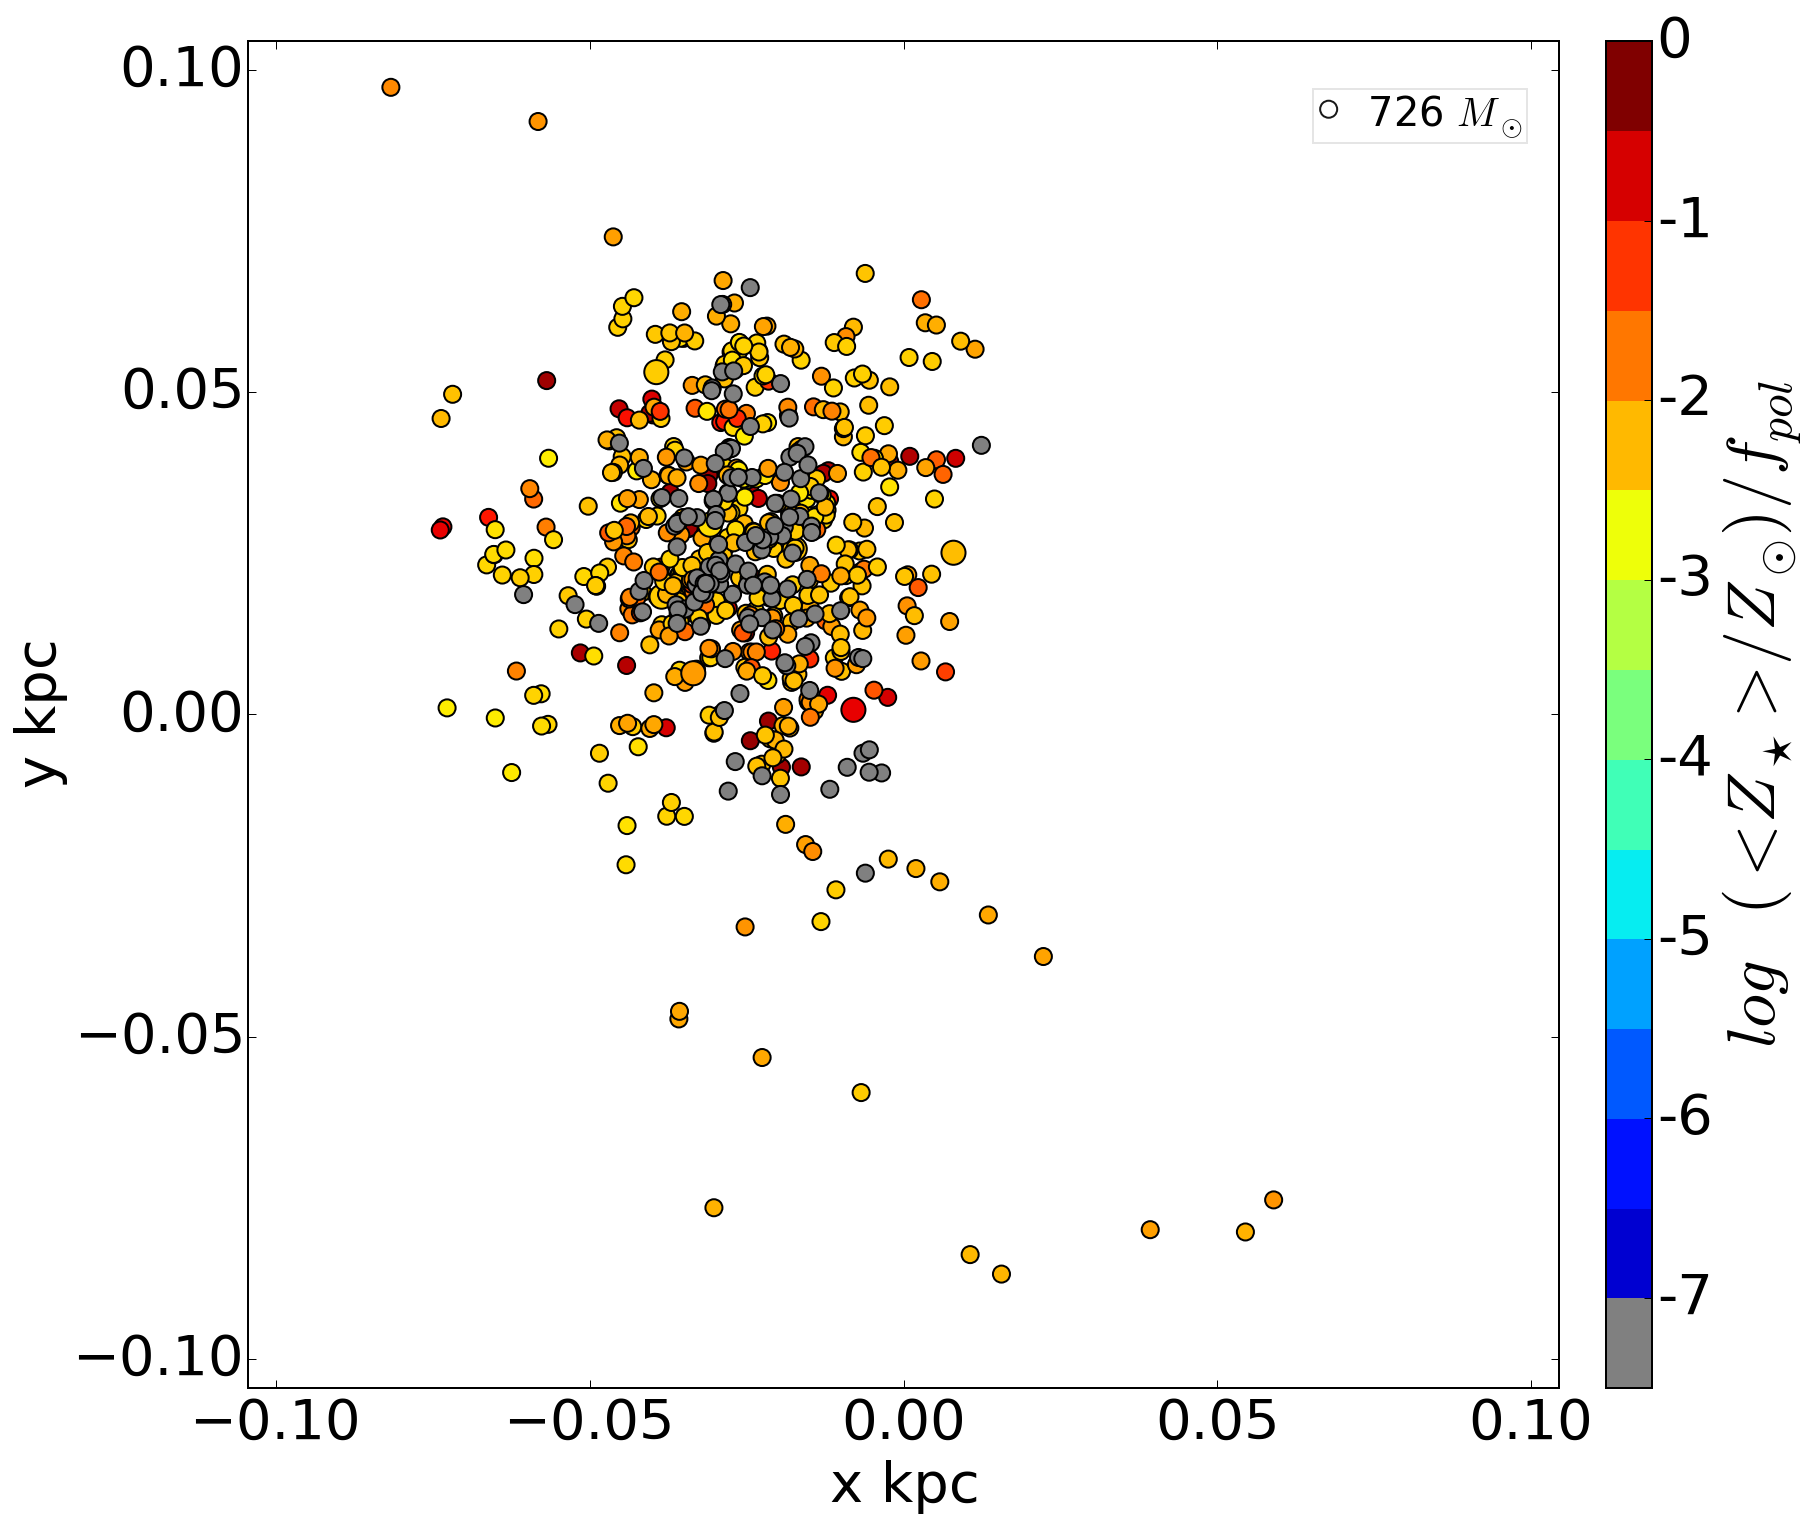

In [170]:
fig = plt.figure()
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
#plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
ax1 = plt.axes(plot_area)
ax1.set_xlim([-sbox/2.0,sbox/2.0])
ax1.set_ylim([-sbox/2.0,sbox/2.0])

xcoord = locs[:,0]; ycoord = locs[:,1]
# Using Z/f_pol here ... So metallicity has been corrected for the polluted fraction
ax1.scatter(xcoord[rngf4], ycoord[rngf4], s=mass[rngf4]/dotNorm, c=zf4, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rngf3], ycoord[rngf3], s=mass[rngf3]/dotNorm, c=zf3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rngf2], ycoord[rngf2], s=mass[rngf2]/dotNorm, c=zf2, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[rngf1], ycoord[rngf1], s=mass[rngf1]/dotNorm, c=zf1, cmap=cmap,vmin=-7.5, vmax=0)

ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                            ticks=ticks, boundaries=bounds, format='%.0f')

ax1.set_xlabel('x kpc')
ax1.set_ylabel('y kpc')

xpos = ax1.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax1.get_ylim()[1] - 0.125 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax1.annotate(legStr,xy=(xpos,ypos), xytext=(xpos+0.01, ypos), horizontalalignment='right', bbox=bbox, size=20)
ax1.scatter(np.array([xpos-0.021]), np.array([ypos+0.0025]), s=np.array([min(mass)])/dotNorm,facecolors='none')

#ax1.locator_params(nbins=5) # Setup the ticks according to the bins
    
ax5.set_ylabel('$log\; (<Z_{\star}>/Z_{\odot})/f_{pol}$', size=34)

## plt.subplots_adjust(left=0.2, bottom=0.15, right=0.80, top=0.85, wspace=.15, hspace=.15)
plt.savefig("SP_Z_locs_z={:04.1f}-{:d}_fpol.pdf".format(z,i))
plt.show()
plt.close()


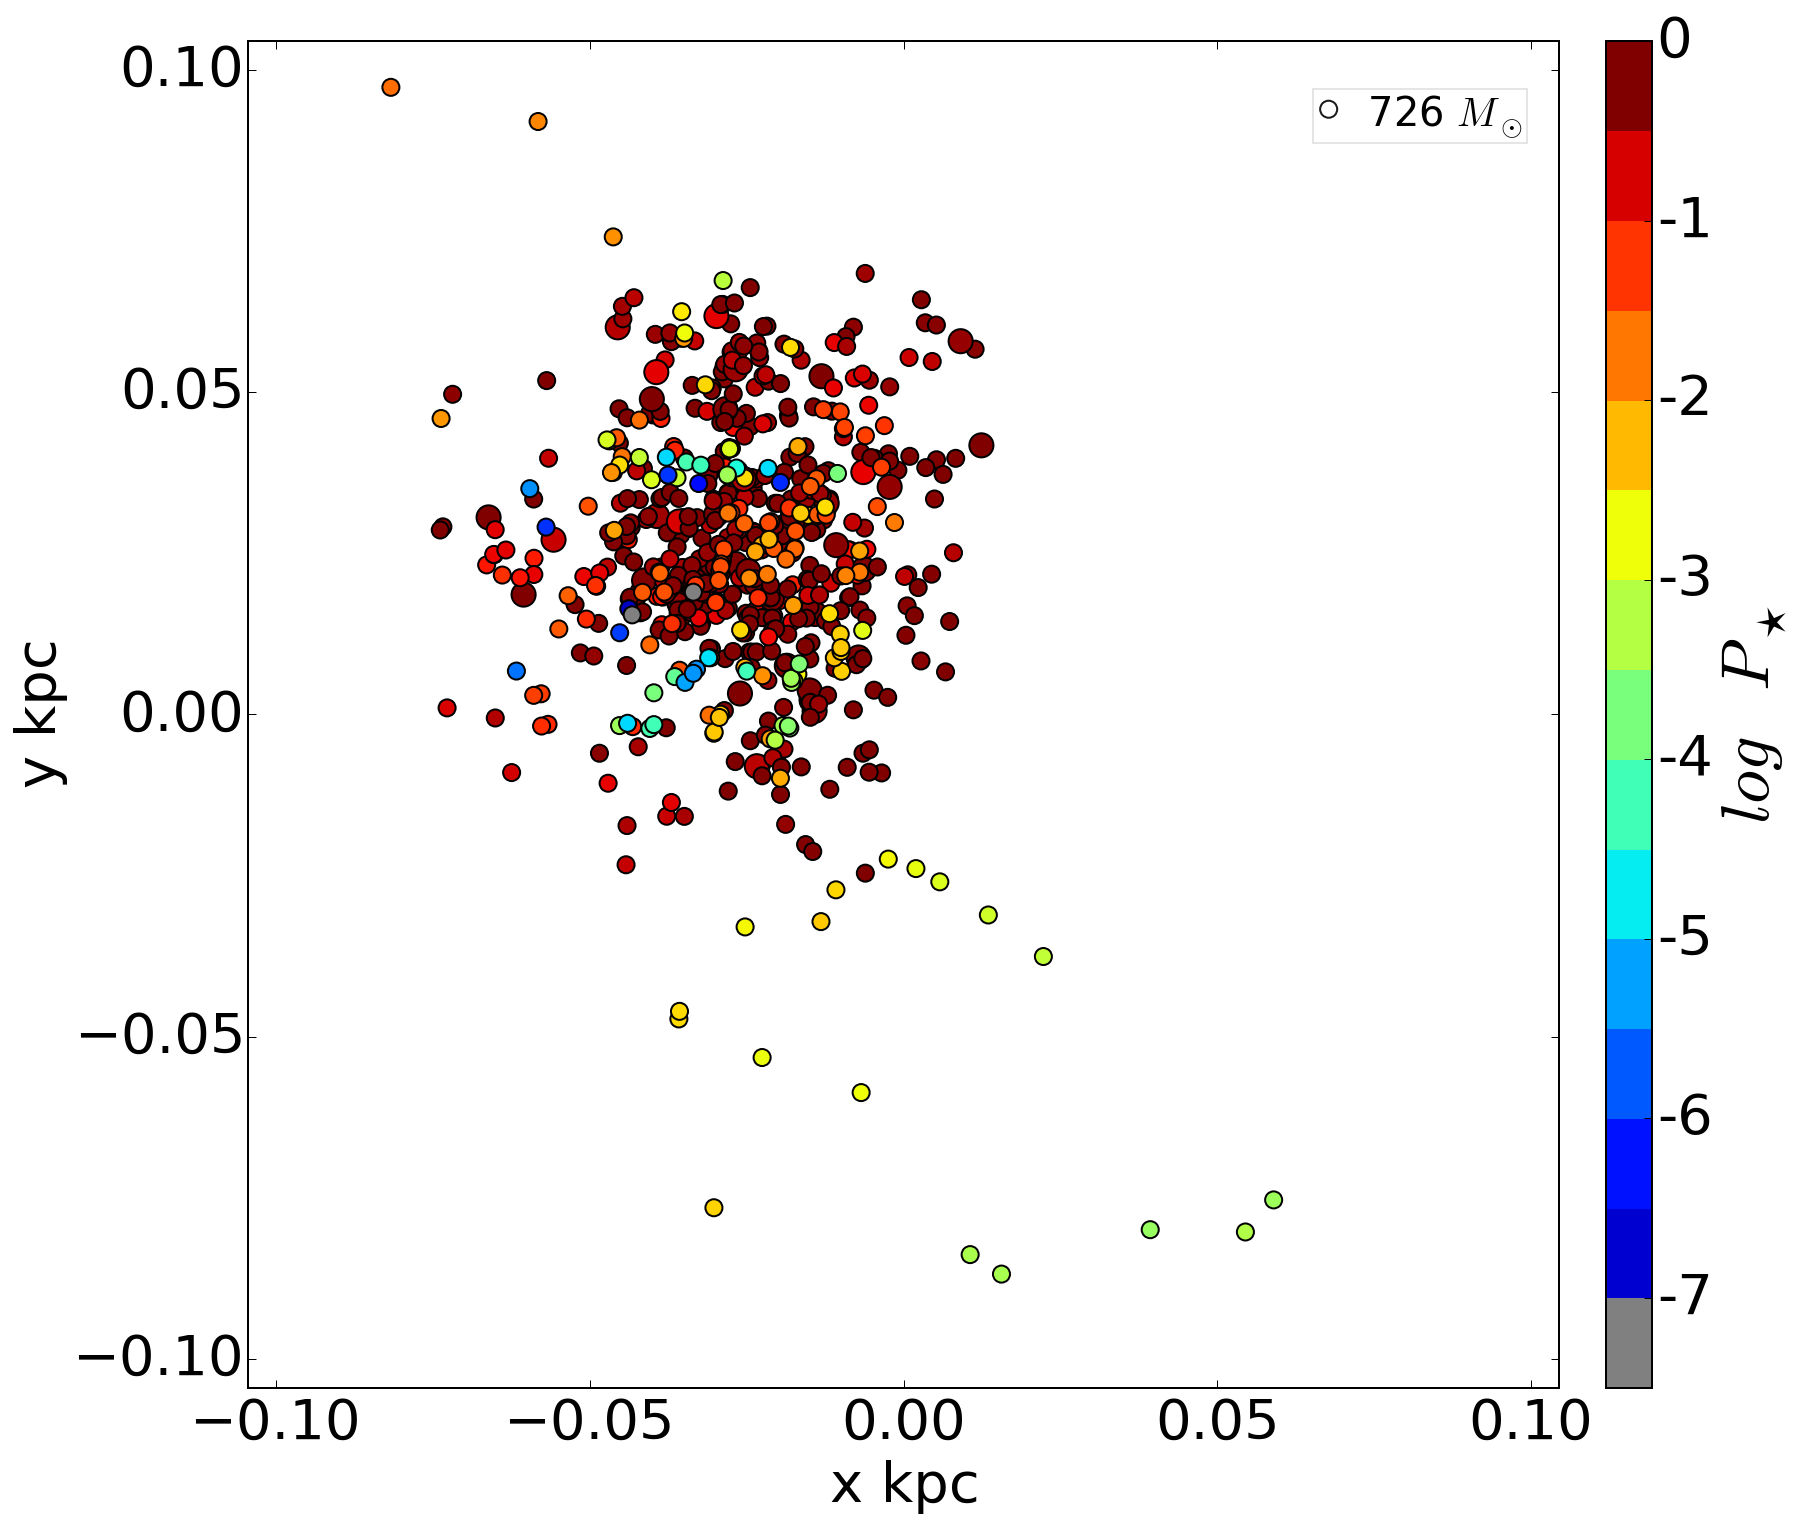

In [173]:
fig = plt.figure()
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
#plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
ax1 = plt.axes(plot_area)
ax1.set_xlim([-sbox/2.0,sbox/2.0])
ax1.set_ylim([-sbox/2.0,sbox/2.0])

xcoord = locs[:,0]; ycoord = locs[:,1]
ax1.scatter(xcoord[pfrng4], ycoord[pfrng4], s=mass[pfrng1]/dotNorm, c=pf4, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pfrng3], ycoord[pfrng3], s=mass[pfrng2]/dotNorm, c=pf3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pfrng2], ycoord[pfrng2], s=mass[pfrng3]/dotNorm, c=pf2, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pfrng1], ycoord[pfrng1], s=mass[pfrng4]/dotNorm, c=pf1, cmap=cmap,vmin=-7.5, vmax=0)

ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                            ticks=ticks, boundaries=bounds, format='%.0f')
ax1.set_xlabel('x kpc')
ax1.set_ylabel('y kpc')

xpos = ax1.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax1.get_ylim()[1] - 0.125 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax1.annotate(legStr,xy=(xpos,ypos), xytext=(xpos+0.01, ypos), horizontalalignment='right', bbox=bbox, size=20)
ax1.scatter(np.array([xpos-0.021]), np.array([ypos+0.0025]), s=np.array([min(mass)])/dotNorm,facecolors='none')

#ax1.locator_params(nbins=5) # Setup the ticks according to the bins
    
ax5.set_ylabel('$log\; P_{\star}$', size=34)

## plt.subplots_adjust(left=0.2, bottom=0.15, right=0.80, top=0.85, wspace=.15, hspace=.15)
plt.savefig("SP_PF_locs_z={:04.1f}-{:d}.pdf".format(z,i))
plt.show()
plt.close()


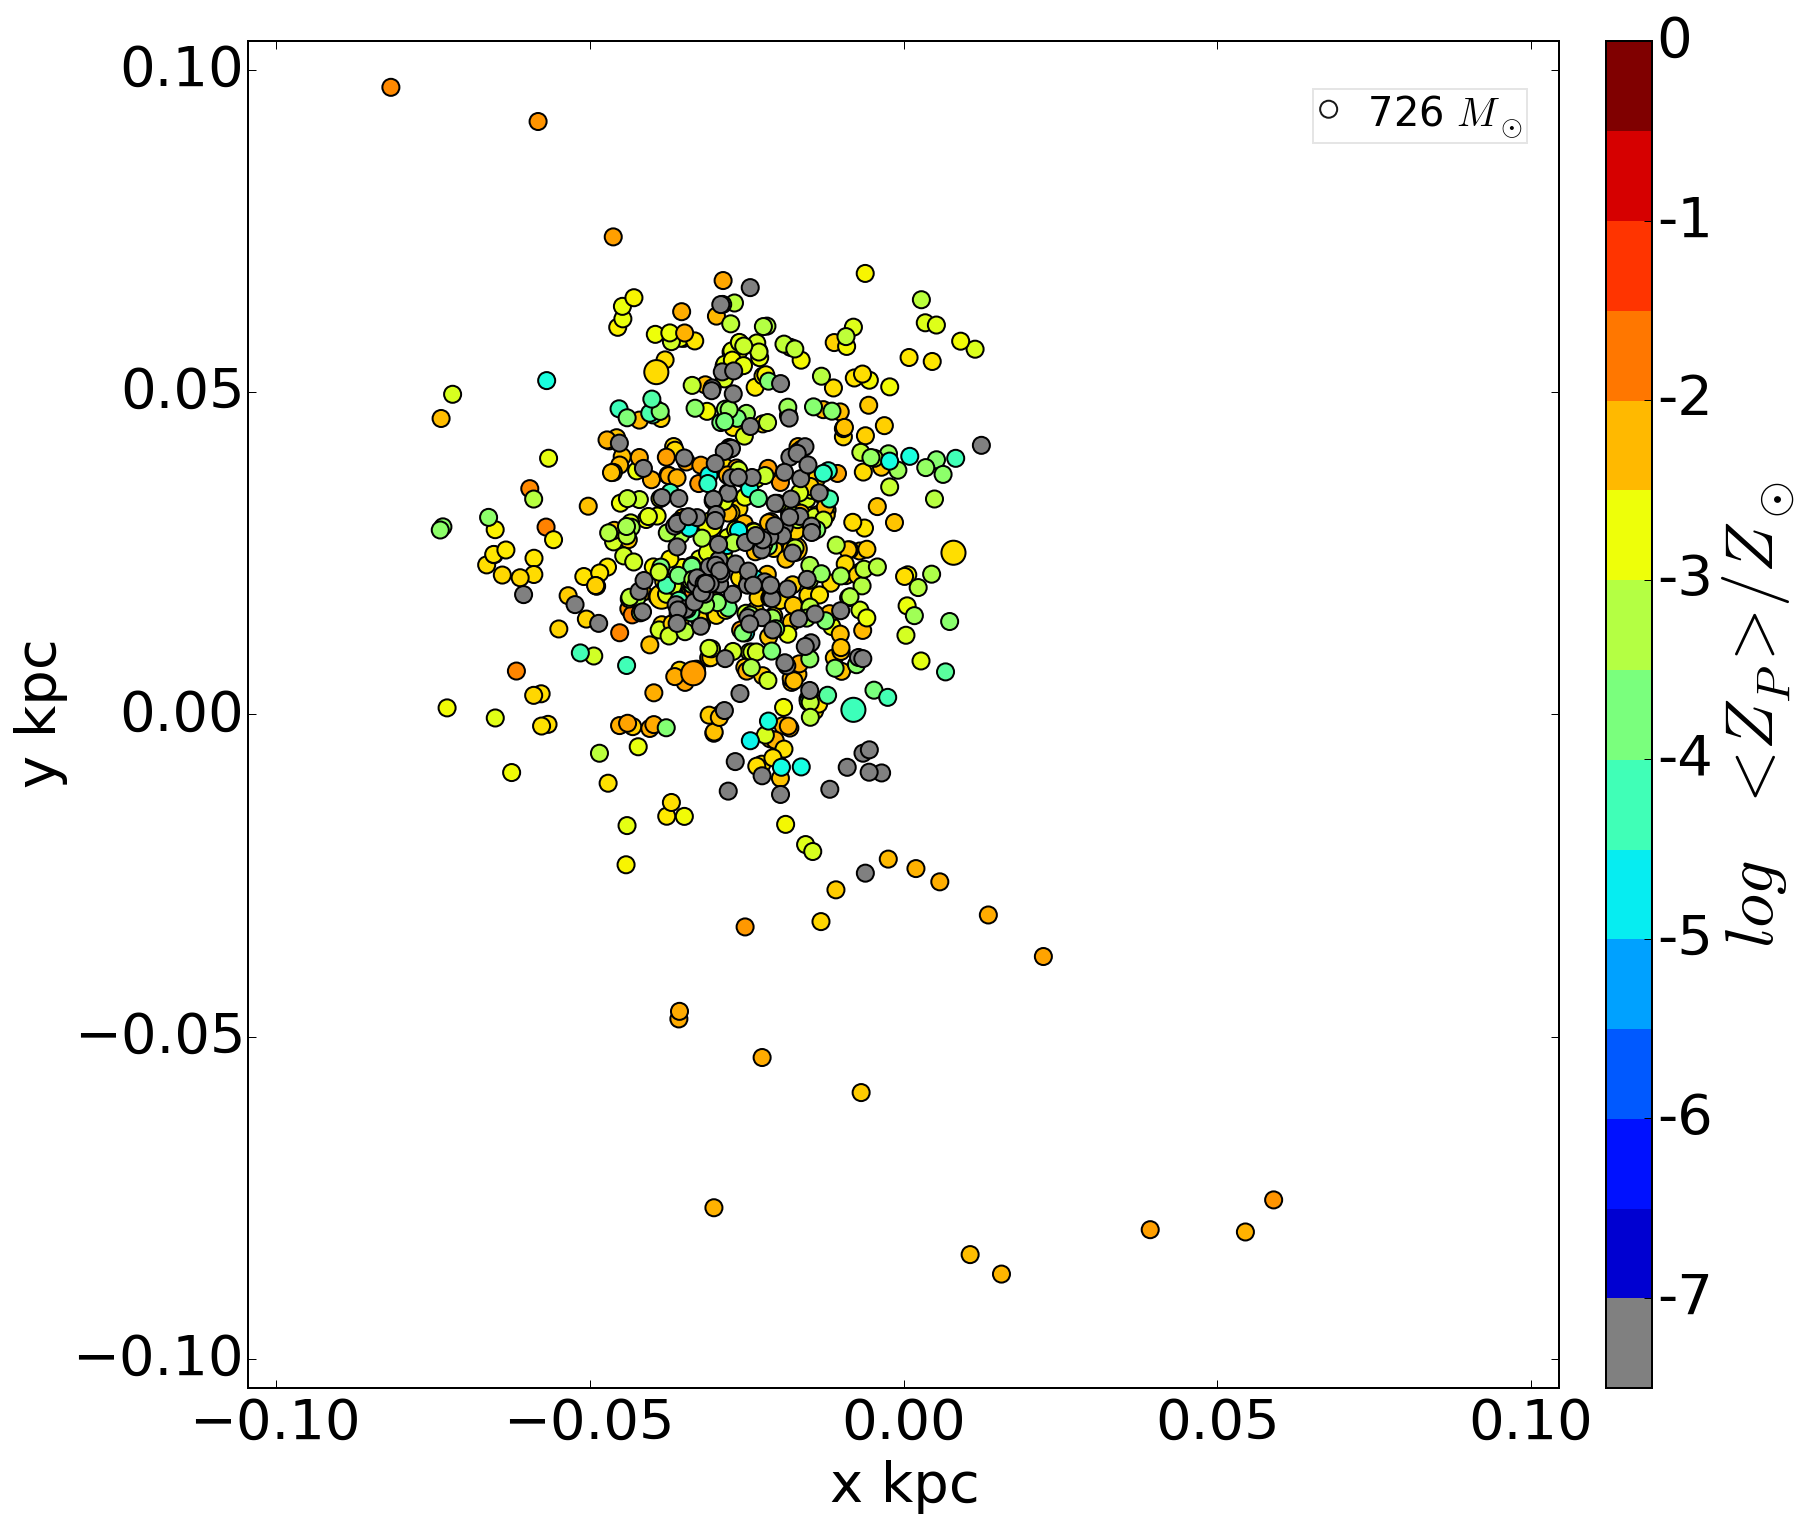

In [174]:
fig = plt.figure()
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
#plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
ax1 = plt.axes(plot_area)
ax1.set_xlim([-sbox/2.0,sbox/2.0])
ax1.set_ylim([-sbox/2.0,sbox/2.0])

xcoord = locs[:,0]; ycoord = locs[:,1]
ax1.scatter(xcoord[pzrng4], ycoord[pzrng4], s=mass[pzrng4]/dotNorm, c=pz4, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrng3], ycoord[pzrng3], s=mass[pzrng3]/dotNorm, c=pz3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrng2], ycoord[pzrng2], s=mass[pzrng2]/dotNorm, c=pz2, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrng1], ycoord[pzrng1], s=mass[pzrng1]/dotNorm, c=pz1, cmap=cmap,vmin=-7.5, vmax=0)

ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                            ticks=ticks, boundaries=bounds, format='%.0f')
ax1.set_xlabel('x kpc')
ax1.set_ylabel('y kpc')

xpos = ax1.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax1.get_ylim()[1] - 0.125 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax1.annotate(legStr,xy=(xpos,ypos), xytext=(xpos+0.01, ypos), horizontalalignment='right', bbox=bbox, size=20)
ax1.scatter(np.array([xpos-0.021]), np.array([ypos+0.0025]), s=np.array([min(mass)])/dotNorm,facecolors='none')

#ax1.locator_params(nbins=5) # Setup the ticks according to the bins
    
ax5.set_ylabel('$log\; <Z_{P}>/Z_{\odot}$', size=34)

## plt.subplots_adjust(left=0.2, bottom=0.15, right=0.80, top=0.85, wspace=.15, hspace=.15)
plt.savefig("SP_PZ_locs_z={:04.1f}-{:d}.pdf".format(z,i))
plt.show()
plt.close()


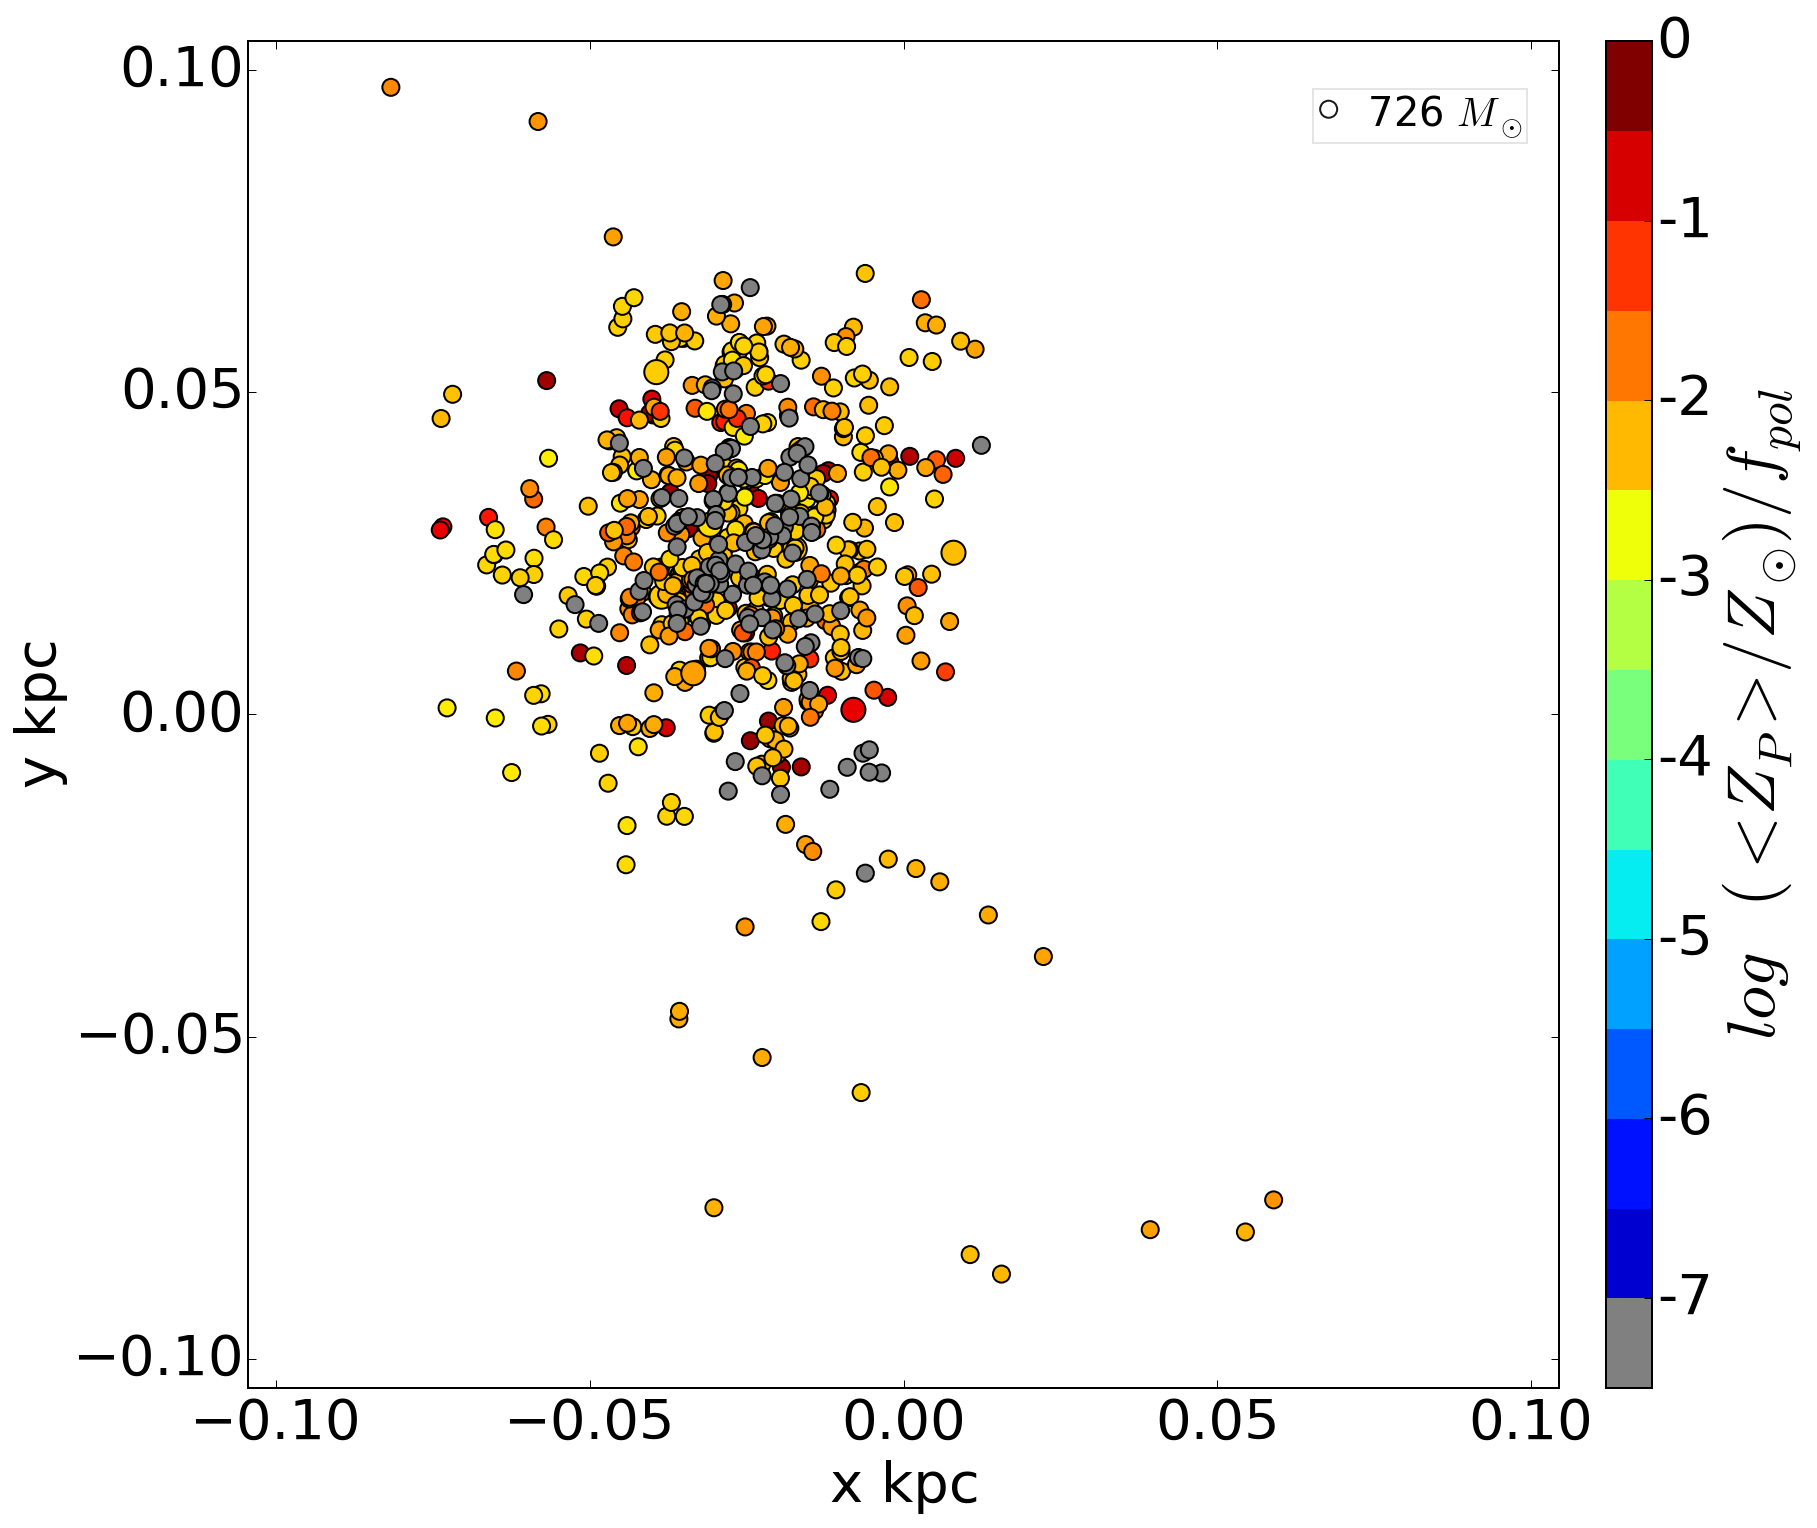

In [175]:
fig = plt.figure()
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
#plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
#plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)
ax1 = plt.axes(plot_area)
ax1.set_xlim([-sbox/2.0,sbox/2.0])
ax1.set_ylim([-sbox/2.0,sbox/2.0])

xcoord = locs[:,0]; ycoord = locs[:,1]
ax1.scatter(xcoord[pzrngf4], ycoord[pzrngf4], s=mass[pzrngf4]/dotNorm, c=pzf4, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrngf3], ycoord[pzrngf3], s=mass[pzrngf3]/dotNorm, c=pzf3, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrngf2], ycoord[pzrngf2], s=mass[pzrngf2]/dotNorm, c=pzf2, cmap=cmap,vmin=-7.5, vmax=0)
ax1.scatter(xcoord[pzrngf1], ycoord[pzrngf1], s=mass[pzrngf1]/dotNorm, c=pzf1, cmap=cmap,vmin=-7.5, vmax=0)

ax5 = fig.add_axes([0.85, 0.1, 0.025, 0.85])
cb = mpl.colorbar.ColorbarBase(ax5, cmap=cmap, norm=norm, spacing='proportional',
                            ticks=ticks, boundaries=bounds, format='%.0f')
ax1.set_xlabel('x kpc')
ax1.set_ylabel('y kpc')

xpos = ax1.get_xlim()[1] - 0.15 * ax1.get_xlim()[1]
ypos = ax1.get_ylim()[1] - 0.125 * ax1.get_ylim()[1]
size = min(mass)
legStr = '    {:.0f}'.format(size)
legStr = legStr + " $M_{\odot}$"
bbox = {'facecolor':'white', 'alpha':0.1, 'pad':4}
ax1.annotate(legStr,xy=(xpos,ypos), xytext=(xpos+0.01, ypos), horizontalalignment='right', bbox=bbox, size=20)
ax1.scatter(np.array([xpos-0.021]), np.array([ypos+0.0025]), s=np.array([min(mass)])/dotNorm,facecolors='none')

#ax1.locator_params(nbins=5) # Setup the ticks according to the bins
    
ax5.set_ylabel('$log\; (<Z_{P}>/Z_{\odot})/f_{pol}$', size=34)

## plt.subplots_adjust(left=0.2, bottom=0.15, right=0.80, top=0.85, wspace=.15, hspace=.15)
plt.savefig("SP_PZ_locs_z={:04.1f}-{:d}_fpol.pdf".format(z,i))
plt.show()
plt.close()


In [135]:
np.sum(mass),np.sum(mass[pzrngf1])+np.sum(mass[pzrngf1])+np.sum(mass[pzrngf1])+np.sum(mass[pzrngf1])

(468006.42600747198, 354088.58277774614)

# Compute histogram for the halo

In [61]:
# Slightly offset bins so we can see the data.
# 51 Z bins from -10 to 0
xrange1 = np.logspace(-7,0,36) # 1e-10, 1e-9.8, 1e-9.6, ... 
xrange2 = np.logspace(-6.98,0.02,36) # 1e-9.96, 1e-9.76, 1e-9.56, ... 
xrange3 = np.logspace(-6.96,0.04,36) # 1e-9.92, 1e-9.72, 1e-9.52, ... 
xrange4 = np.logspace(-6.94,0.06,36) # 1e-9.92, 1e-9.72, 1e-9.52, ... 

In [62]:
# Make these points closer to -7
Z[Z<1e-5] = 1e-7
Zf[Zf<1e-5] = 1e-7
PZ[PZ<1e-5] = 1e-7

# Reset PZ < Z_crit to 0 so we don't end up with 1e-8/1e-8 = 1 for primordial metals... 
temp = PZ
temp[temp < 1e-5] = 0.0

bins    = np.logspace(-7, 0, 36) # Log bins for histogram data 
psm     = np.zeros(len(bins)-1) # Pristine Stellar mass in that bin
tsm     = np.zeros(len(bins)-1) # total mass
zsm     = np.zeros(len(bins)-1) # total polluted mass
primsm  = np.zeros(len(bins)-1) # Primordial stellar mass
for indx2,j in enumerate(bins):
    if indx2 < len(bins)-1:
        theBin = (Z >= j) & (Z < bins[indx2+1]) # This selects for sp's in the bin

        tsm[indx2] = np.sum(mass[theBin])
        psm[indx2] = np.sum(PPF[theBin] * mass[theBin])
        # For sp's that are in our bin:
        #   Compute the polluted fraction * pristine metals fraction: f_pol * pzf/Z
        #   Compute the mass of stars that are polluted only by pristine metals
        primsm[indx2] = np.sum(fpol[theBin] * (temp[theBin] / Z[theBin]) * mass[theBin])
        zsm[indx2]    = np.sum(fpol[theBin] * mass[theBin])

In [47]:
len(zsm)

35

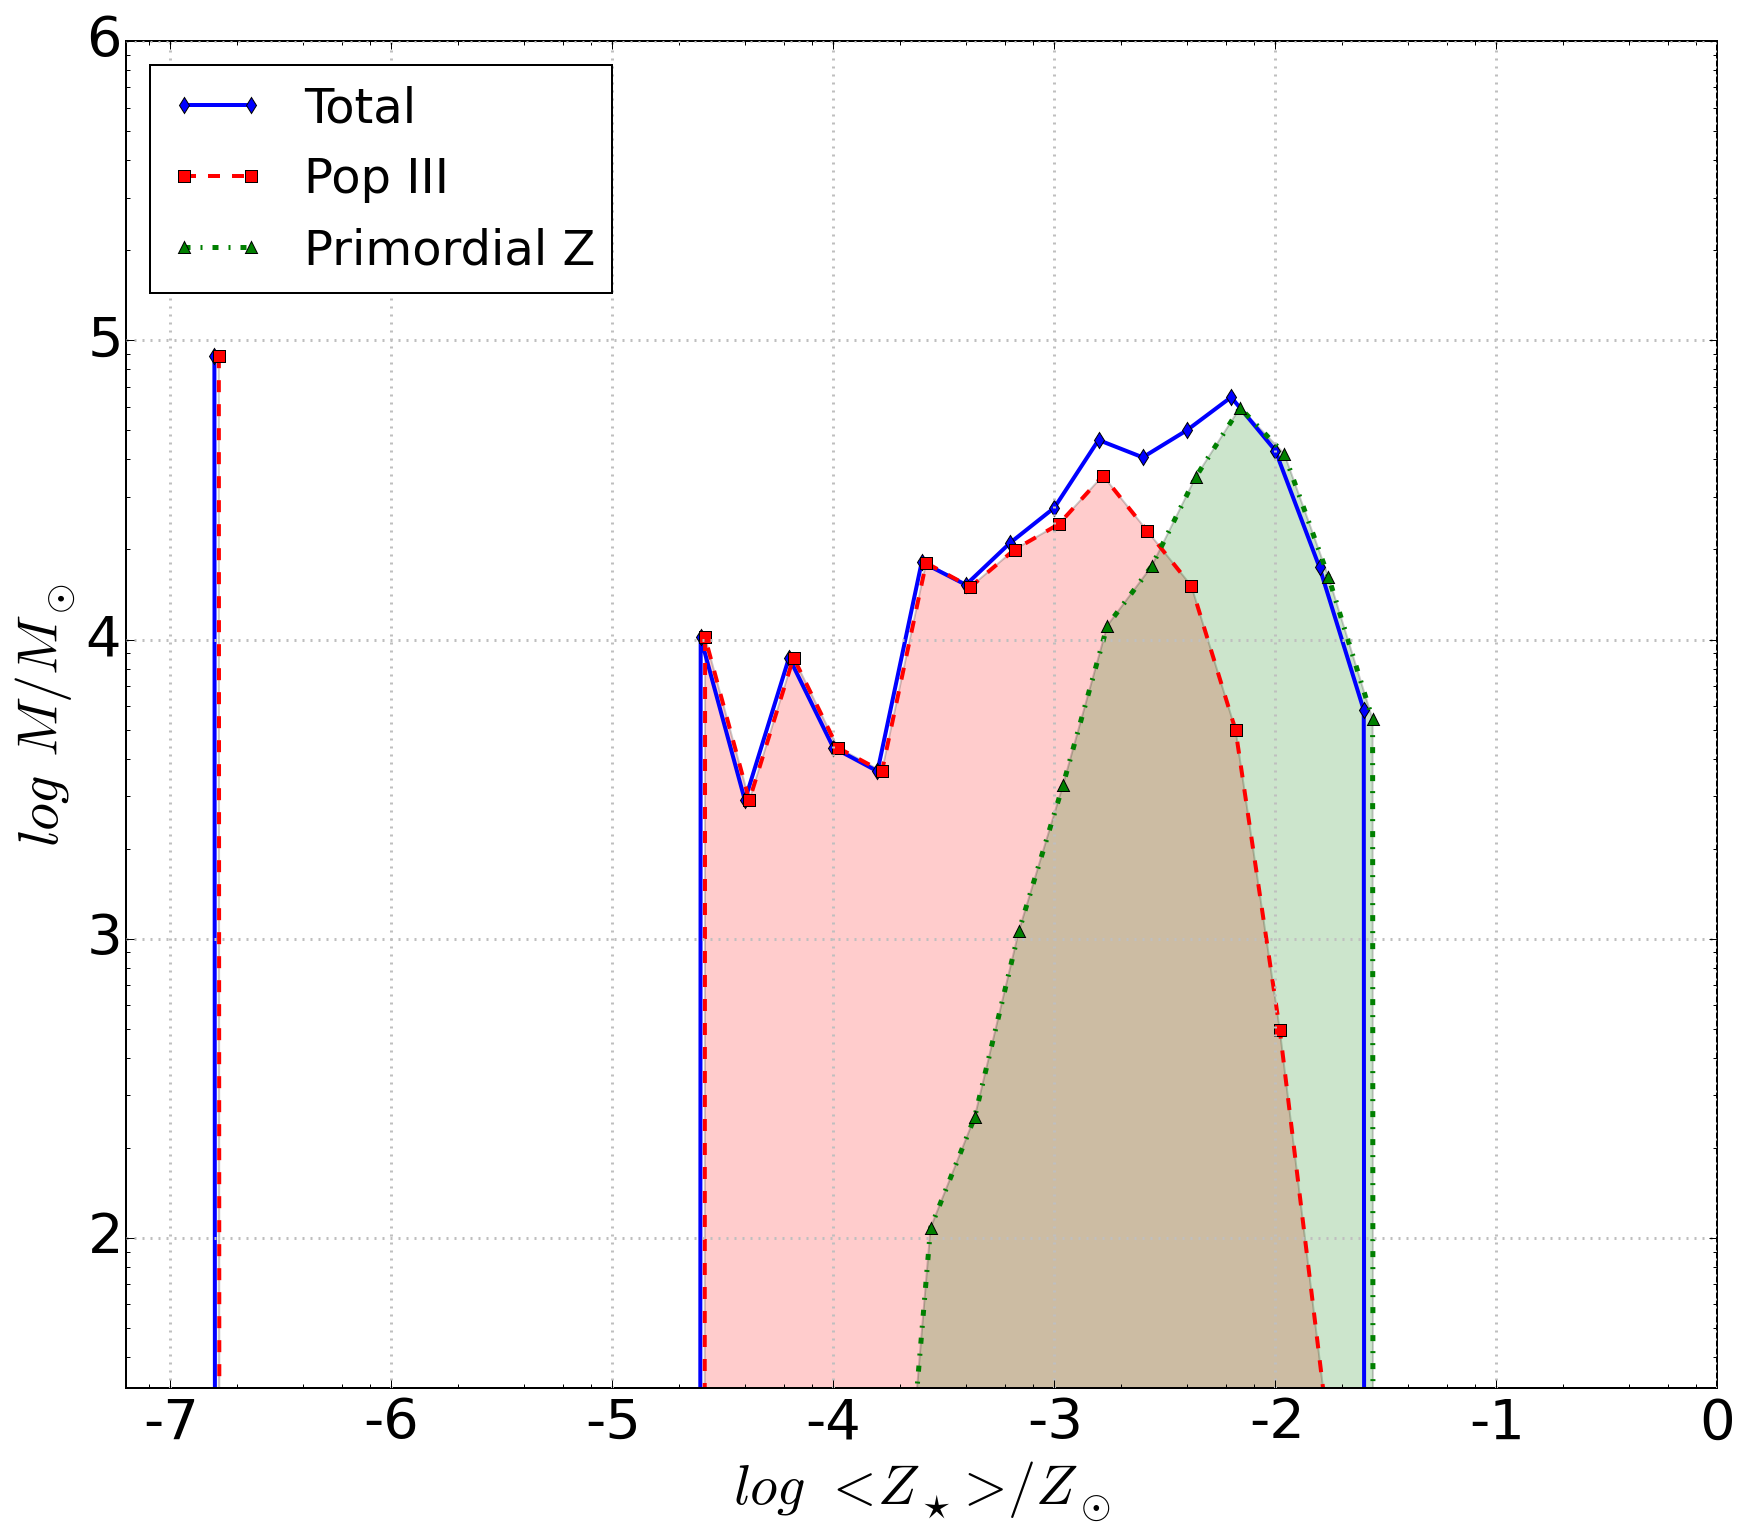

In [63]:
#plt.rcParams['figure.figsize'] = (13,11)
#plt.rcParams['font.size'] = 28
# We're gonna cheat a bit and just move the histogram value to the lower edge of the bin... 
# Our bins are small so this shouldn't even show... 
histRect = [0.1, 0.1, .85, 0.85]
axHist   = plt.axes(histRect)
custom_formatter = FuncFormatter(formatter)

axHist.set_xscale('log')
axHist.set_yscale('log')
axHist.set_xlim([2*10**-7.5,1])
axHist.set_ylim([10**1.5,10**6.0])

axHist.set_xlabel("$log\, <Z_{\star}> /Z_{\odot}$", size=28)
axHist.set_ylabel('$log\, M/M_{\odot}$', size=28)

axHist.plot(xrange1[1:36],tsm,'b-d',  linewidth = 2.0)
axHist.plot(xrange2[1:36],psm, 'r--s', linewidth = 2.0 )
axHist.plot(xrange3[1:36],primsm,'g-.^', linewidth = 2.5 )
#axHist.plot(xrange4[1:36],zsm,'m:*', linewidth = 2.5 )
axHist.xaxis.set_major_formatter(custom_formatter)
axHist.yaxis.set_major_formatter(custom_formatter)
axHist.fill_between(xrange2[1:36], 0, psm, facecolor='r', alpha=0.2)
axHist.fill_between(xrange3[1:36], 0, primsm, facecolor='g', alpha=0.2)

axHist.grid(color='0.75', linestyle=':', linewidth=1.5)
axHist.legend(['Total','Pop III','Primordial Z'],loc='upper left', fontsize=24 )
plt.savefig("Hist_HaloData_z={:04.1f}SFRegion.pdf".format(z))
plt.show()

In [64]:
# Make these points closer to -7
Z[Z<1e-5] = 1e-7
Zf[Zf<1e-5] = 1e-7
PZ[PZ<1e-5] = 1e-7

# Reset PZ < Z_crit to 0 so we don't end up with 1e-8/1e-8 = 1 for primordial metals... 
temp = PZ
temp[temp < 1e-5] = 0.0

bins    = np.logspace(-7, 0, 36) # Log bins for histogram data 
psm     = np.zeros(len(bins)-1) # Pristine Stellar mass in that bin
tsm     = np.zeros(len(bins)-1) # total mass
zsm     = np.zeros(len(bins)-1) # total polluted mass
primsm  = np.zeros(len(bins)-1) # Primordial stellar mass
for indx2,j in enumerate(bins):
    if indx2 < len(bins)-1:
        theBin = (Zf >= j) & (Zf < bins[indx2+1]) # This selects for sp's in the bin that have Z/f_pol

        tsm[indx2] = np.sum(mass[theBin])
        psm[indx2] = np.sum(PPF[theBin] * mass[theBin])
        # For sp's that are in our bin:
        #   Compute the polluted fraction * pristine metals fraction: f_pol * pzf/Z
        #   Compute the mass of stars that are polluted only by pristine metals
        primsm[indx2] = np.sum(fpol[theBin] * (temp[theBin] / Z[theBin]) * mass[theBin])
        zsm[indx2]    = np.sum(fpol[theBin] * mass[theBin])

In [65]:
bins

array([  1.00000000e-07,   1.58489319e-07,   2.51188643e-07,
         3.98107171e-07,   6.30957344e-07,   1.00000000e-06,
         1.58489319e-06,   2.51188643e-06,   3.98107171e-06,
         6.30957344e-06,   1.00000000e-05,   1.58489319e-05,
         2.51188643e-05,   3.98107171e-05,   6.30957344e-05,
         1.00000000e-04,   1.58489319e-04,   2.51188643e-04,
         3.98107171e-04,   6.30957344e-04,   1.00000000e-03,
         1.58489319e-03,   2.51188643e-03,   3.98107171e-03,
         6.30957344e-03,   1.00000000e-02,   1.58489319e-02,
         2.51188643e-02,   3.98107171e-02,   6.30957344e-02,
         1.00000000e-01,   1.58489319e-01,   2.51188643e-01,
         3.98107171e-01,   6.30957344e-01,   1.00000000e+00])

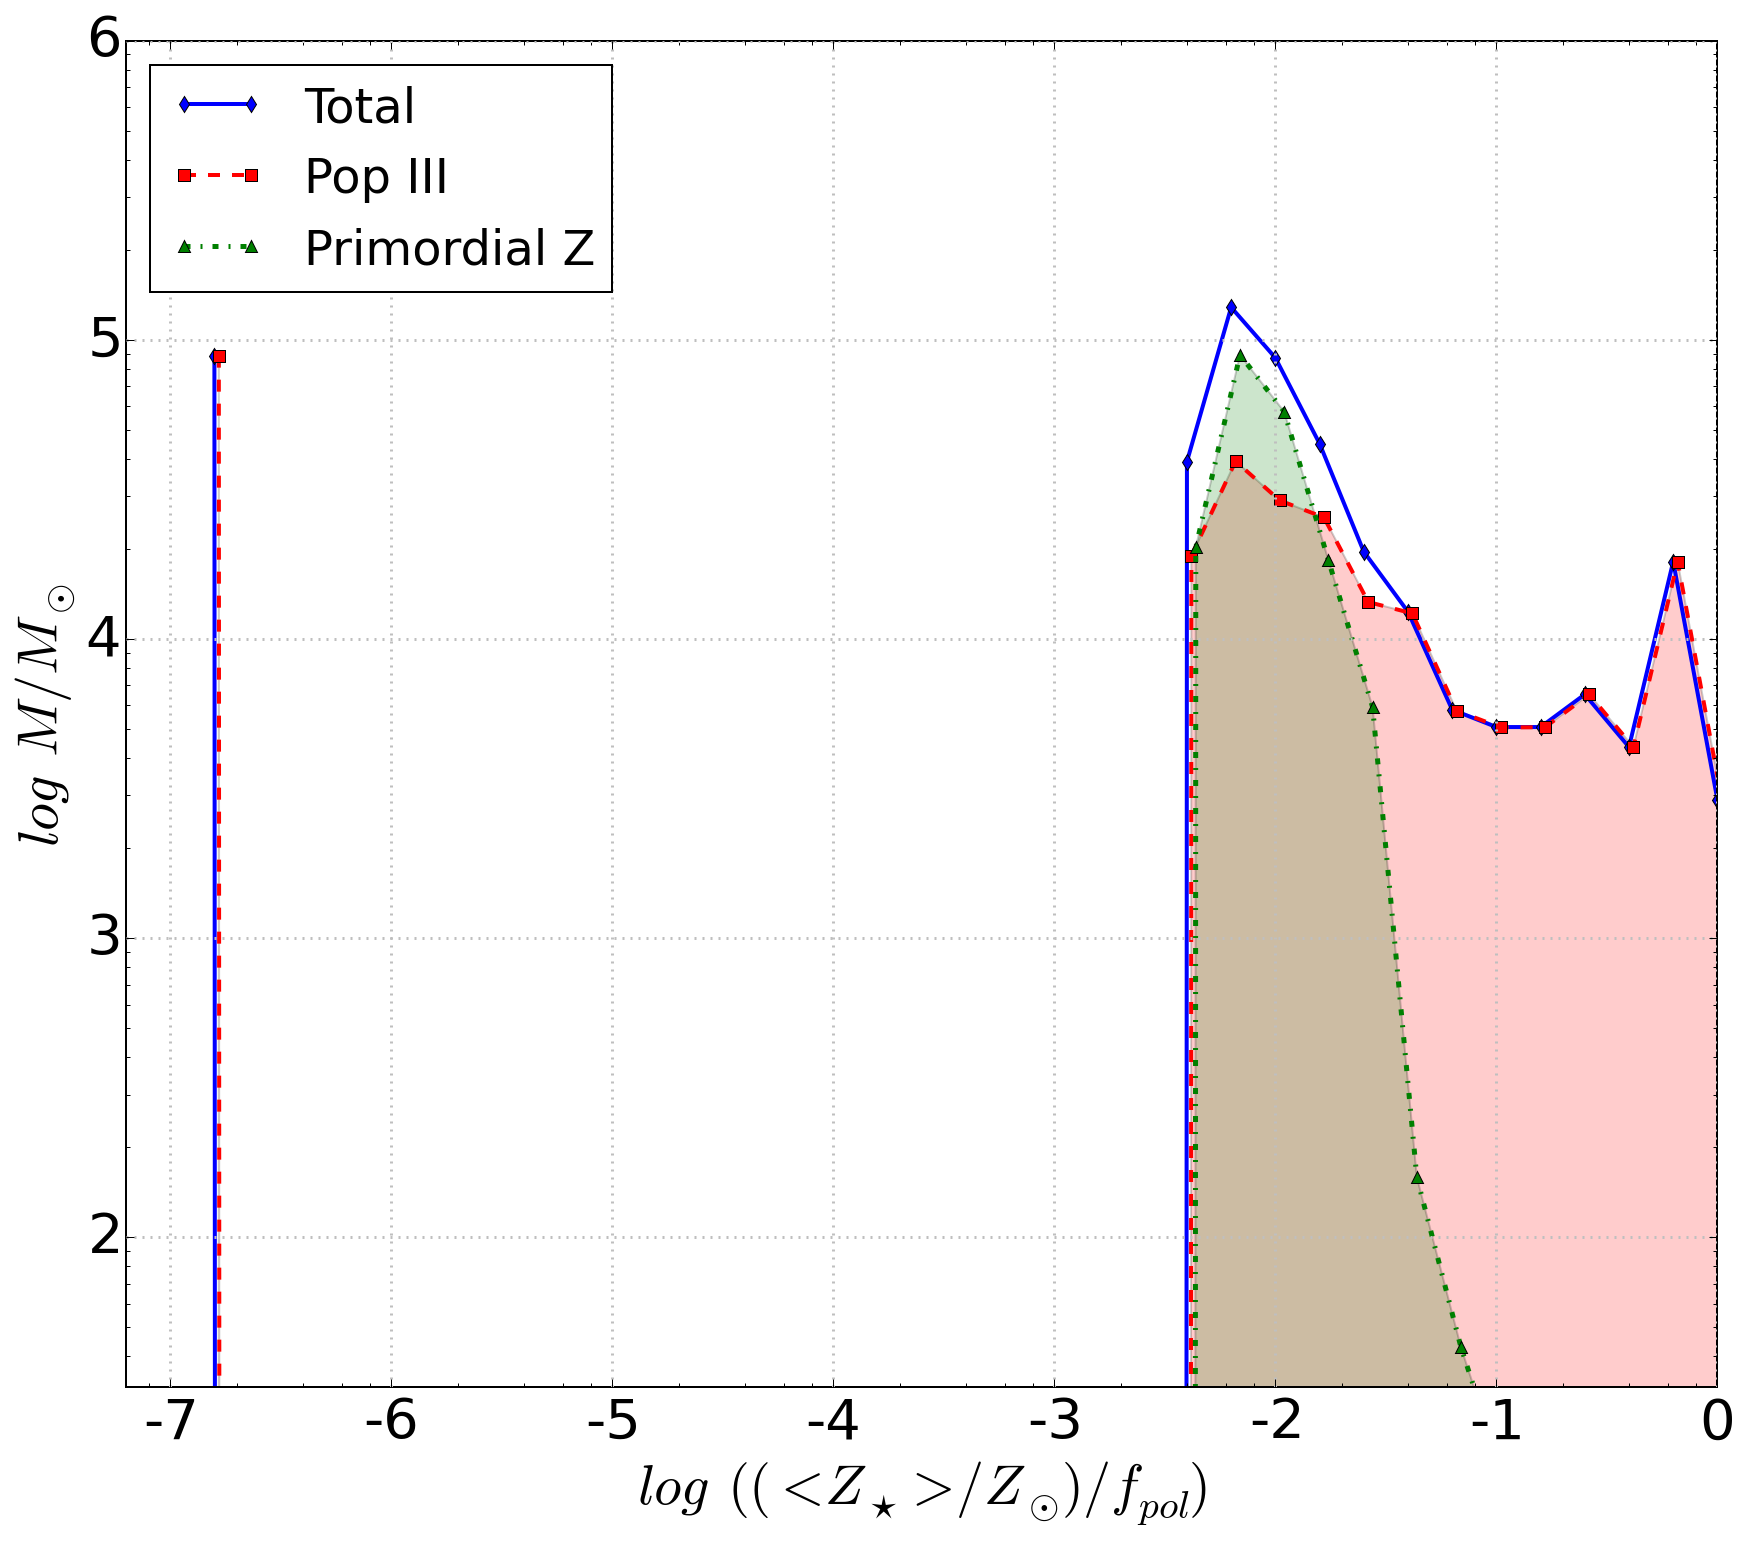

In [76]:
plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 28
# We're gonna cheat a bit and just move the histogram value to the lower edge of the bin... 
# Our bins are small so this shouldn't even show... 
histRect = [0.1, 0.1, .85, 0.85]
axHist   = plt.axes(histRect)
custom_formatter = FuncFormatter(formatter)

axHist.set_xscale('log')
axHist.set_yscale('log')
axHist.set_xlim([2*10**-7.5,1])
axHist.set_ylim([10**1.5,10**6.0])

axHist.set_xlabel("$log\, ((<Z_{\star}> /Z_{\odot})/f_{pol})$", size=28)
axHist.set_ylabel('$log\, M/M_{\odot}$', size=28)

axHist.plot(xrange1[1:36],tsm,'b-d',  linewidth = 2.0)
axHist.plot(xrange2[1:36],psm, 'r--s', linewidth = 2.0 )
axHist.plot(xrange3[1:36],primsm,'g-.^', linewidth = 2.5 )
#axHist.plot(xrange4[1:36],zsm,'m:*', linewidth = 2.5 )
axHist.xaxis.set_major_formatter(custom_formatter)
axHist.yaxis.set_major_formatter(custom_formatter)
axHist.fill_between(xrange2[1:36], 0, psm, facecolor='r', alpha=0.2)
axHist.fill_between(xrange3[1:36], 0, primsm, facecolor='g', alpha=0.2)

axHist.grid(color='0.75', linestyle=':', linewidth=1.5)
axHist.legend(['Total','Pop III','Primordial Z'],loc='upper left', fontsize=24 )
plt.savefig("Hist_HaloData_z={:04.1f}SFRegion.pdf".format(z))
plt.show()

In [70]:
Zf[Zf>=1],PZf[PZf>=1]

(array([], dtype=float64), array([], dtype=float64))

In [74]:
Z[Z>1e-1],Zf[Zf>1e-1]

(array([], dtype=float64),
 array([ 0.62633701,  0.43033668,  0.47020803,  0.34258385,  0.66584538,
         0.52263902,  0.60323285,  0.34667058,  0.46980992,  0.65177533,
         0.67217565,  0.13491345,  0.18063914,  0.48129721,  0.41697252,
         0.49305812,  0.13460336,  0.17169009,  0.44468218,  0.15477742,
         0.20149804,  0.41133237,  0.16817972,  0.40632474,  0.19465352,
         0.58653308,  0.32162347,  0.53561615,  0.10285603,  0.24783775,
         0.62564245,  0.51693883,  0.66903856,  0.21340285,  0.12097045,
         0.11234659,  0.52679995,  0.26599492,  0.61897867,  0.20326786,
         0.62076691,  0.31567059,  0.49202922,  0.27708082,  0.60811934,
         0.50273916,  0.12321788,  0.39876998,  0.55522202,  0.57320655]))